In [84]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_fastq(file_path):
    
    '''This function reads in and parses a fastq file of the following structure:
    (0) - name, (1) - sq, (2) - nothing, (3) - quality. Returns a dict with the 
    corresponding lists of names, sqs and quality.'''
    
    with open(file_path, 'r') as f:
        lines=f.readlines()
    
    fastq={'names':[],'sqs':[],'quality':[]}
    
    for i in range(0,len(lines),4):
        fastq['names'].append(lines[i].rstrip('\n'))
    for i in range(1,len(lines),4):
        fastq['sqs'].append(lines[i].rstrip('\n'))
    for i in range(3,len(lines),4):
        fastq['quality'].append(lines[i].rstrip('\n'))
        
    return fastq

In [3]:
def revcomp(sq):
    
    '''This function returns reverse compliment of the input sequence.'''
    
    revcomp_sq=''
    compdict={'A':'T','T':'A','C':'G','G':'C'}
    for nt in sq[::-1]:
        revcomp_sq+=compdict[nt]
    return revcomp_sq

In [4]:
def slicer(sub_str,my_str,before=True):
    
    '''This function slices the input string (my_string) either up until the regexp found (before=True),
    or after (in the latter case, the regexp is also cut away from my_str). The function also returns
    index of regexp found -- in order to be able to use it with other strings, f.e. quality.'''
    
    index=re.search(sub_str,my_str).start()
    
    if index!=-1:
        if before:
            return my_str[index:], index
        else:
            return my_str[:index], index
        

In [5]:
def find_start_and_trim(pattern, sq, quality):
    
    ''''This function searches for pattern (both forward and reverse complement) 
    in sq and cuts it up until this pattern. It cuts the quality sequence accordingly, 
    so that only the quality scores that correspond to the obtained trimmed sequence 
    are stored. It also performs reverse complement of sequences, which are not 
    oriented in the right way.'''
    
    if re.search(pattern,sq):
        sq_trimmed, ind = slicer(pattern,sq)
        return sq_trimmed, quality[ind:]
        
    elif re.search(revcomp(pattern),sq):
        sq_trimmed, ind = slicer(pattern,revcomp(sq))
        return sq_trimmed, quality[::-1][ind:]
        
    else:
        return '',''

In [7]:
file_path='./data/quality_filtered/reads.filtered.fastq'
fastq = parse_fastq(file_path)

In [8]:
start_pattern='ATGAGCA'

sq_trimmed_start={}
quality_trimmed_start={}

for i, sq in enumerate(fastq['sqs']):
    sq_trimmed, quality_trimmed = find_start_and_trim(start_pattern, sq, fastq['quality'][i])
    if sq_trimmed!='':
        sq_trimmed_start[fastq['names'][i]], quality_trimmed_start[fastq['names'][i]] = sq_trimmed, quality_trimmed
        

In [9]:
bc_pattern=r'GGAACA(.){20}'

In [20]:
def find_barcode(bc_pattern,sq,quality,indentation,bc_length):
    
    '''This function extracts barcodes from sequences, searching for the input pattern and 
    adjusting for the indentation of the library design. It crops the target sequence and
    the corresponding quality string up untilthe start of the pattern. It also splits the 
    quality str into the barcode and the target sequence parts. The output is: bc sequence, 
    bc quality, target sq, target sq quality.'''
    
    bc = re.search(bc_pattern,sq).group()[indentation:]
    sq_trimmed, ind = slicer(bc_pattern,sq,before=False)
    bc_quality = quality[ind+indentation:ind+bc_length+indentation]
    
    return bc, bc_quality, sq_trimmed, quality[:ind]

In [11]:
sq_trimmed_bc={}
quality_trimmed_bc={}

sq_bc={}
quality_bc={}

for name in sq_trimmed_start:
    
    sq = sq_trimmed_start[name]
    quality = quality_trimmed_start[name]
    
    if re.search(bc_pattern,sq):
        sq_bc[name],quality_bc[name],sq_trimmed_bc[name],
        quality_trimmed_bc[name]=find_barcode(bc_pattern,sq,quality,6,20)

In [12]:
with open('data/barcodes_extracted/trimmed_sqs.fasta','w+') as f:
    for name in sq_trimmed_bc:
        f.write('>'+name+'\n'+sq_trimmed_bc[name]+'\n'+'+'+'\n'+quality_trimmed_bc[name]+'\n')
        
with open('data/barcodes_extracted/barcodes.fasta','w+') as f:
    for name in sq_trimmed_bc:
        f.write('>'+name+'\n'+sq_bc[name]+'\n'+'+'+'\n'+quality_bc[name]+'\n')

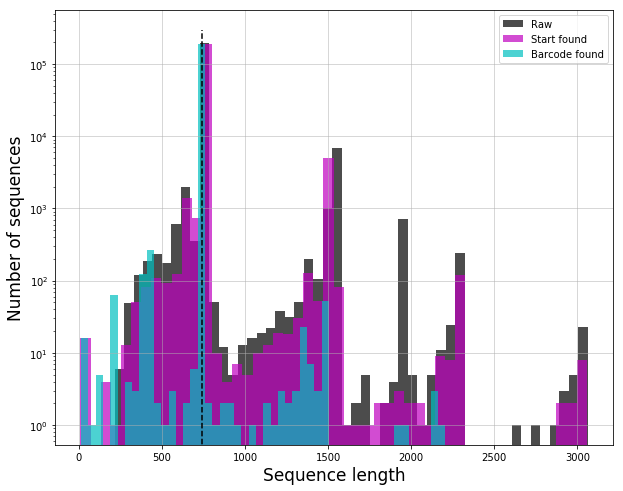

In [13]:
log=True

plt.figure(figsize=[10,8])
plt.hist([len(l) for l in fastq['sqs']],bins=50,log=log,color='k',alpha=0.7,label='Raw')
plt.hist([len(l) for l in sq_trimmed_start.values()],bins=50,log=log,color='m',alpha=0.7, label='Start found')
plt.hist([len(l) for l in sq_trimmed_bc.values()],bins=50,log=log,color='c',alpha=0.7, label='Barcode found')
plt.grid(lw=0.5)
plt.plot([740,740],[0,300000],'--k')
plt.legend()
plt.xlabel('Sequence length',fontsize=17)
plt.ylabel('Number of sequences',fontsize=17)
plt.savefig('figures/length_distribution_%s_scale.png' % ('log' if log else 'linear'))

In [41]:
def filter_by_length(sq_trimmed_bc,length=733):
    names_filtered=[]
    for name in sq_trimmed_bc:
        if len(sq_trimmed_bc[name])==length:
            names_filtered.append(name)
    return names_filtered

In [46]:
names_filtered = filter_by_length(sq_trimmed_bc)

with open('data/barcodes_extracted/trimmed_sqs.filtered_by_length.fasta','w+') as f:
    for name in names_filtered: 
        f.write('>'+name+'\n'+sq_trimmed_bc[name]+'\n'+'+'+'\n'+quality_trimmed_bc[name]+'\n')

with open('data/barcodes_extracted/barcodes.filtered_by_length.fasta','w+') as f:
    for name in names_filtered: 
        f.write('>'+name+'\n'+sq_bc[name]+'\n'+'+'+'\n'+quality_bc[name]+'\n')

In [59]:
true_sq = 'ATGAGCAAGGGCGAGGAGCTGTTCACCGGGATCGTGCCCGTCCTGATTGAGCTGGACGGCGACGTACACGGCCACAAGTTCAGCGTGCGCGGCGAGGGCGAGGGCGATGCCGACTACGGCAAGCTGGAGATCAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGTCGTACGGCATTTTGTGCTTCGCGCGCTACCCCGAACACATGAAGATGAACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACATCCAGGAGCGCACCATCTTCTTCCAGGACGACGGCAAGTACAAGACCCGTGGGGAGGTGAAGTTCGAGGGCGACACACTGGTGAACCGCATCGAGCTGAAGGGCATGGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTTTAACAGCCACAACGTCTATATCATGCCAGACAAGGCTAATAACGGCCTGAAGGTGAACTTCAAGATCCGCCACAACATCGAGGGCGGCGGGGTGCAGCTCGCCGACCACTACCAGACGAACGTTCCCTTGGGCGACGGCCCCGTGCTGATCCCCATCAACCACTACCTGAGCTGTCAGACAGCCATCAGCAAAGACCGTAACGAGACTCGCGATCACATGGTCTTTCTGGAGTTCTTTAGTGCCTGTGGGCATACTCACGGCATGGACGAGCTGTACAAGTGATGATGAGCGGCGCCTA'

In [50]:
filtered_sqs=[]

for name in names_filtered:
    filtered_sqs.append(sq_trimmed_bc[name])

In [53]:
alignment = pd.DataFrame(columns=list(true_seq))

In [58]:
def extract_mutations(true_sq,mut_sq):
    mutations=[]
    for i,nt in enumerate(true_sq):
        if nt!=mut_sq[i]:
            mutations.append(nt+str(i)+mut_sq[i])

    return ':'.join(mutations)

In [60]:
mutants=[]

for mutant in filtered_sqs:
    mutants.append(extract_mutations(true_sq,mutant))

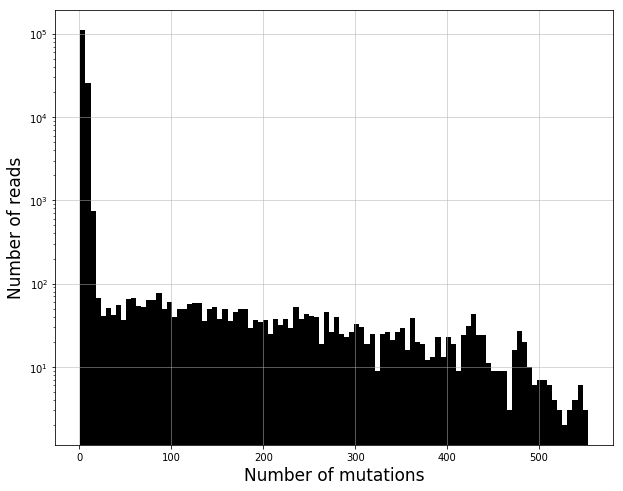

In [67]:
plt.figure(figsize=[10,8])
plt.hist([len(x.split(':')) for x in mutants], bins=100, color='k', log=True)
plt.grid(lw=0.5)
plt.xlabel('Number of mutations',fontsize=17)
plt.ylabel('Number of reads',fontsize=17);

In [73]:
counter = [0]*len(true_sq)
for mutant in mutants:
    if len(mutant)>0:
        for i,mutation in enumerate(mutant.split(':')):
            counter[int(mutation[1:-1])]+=1

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


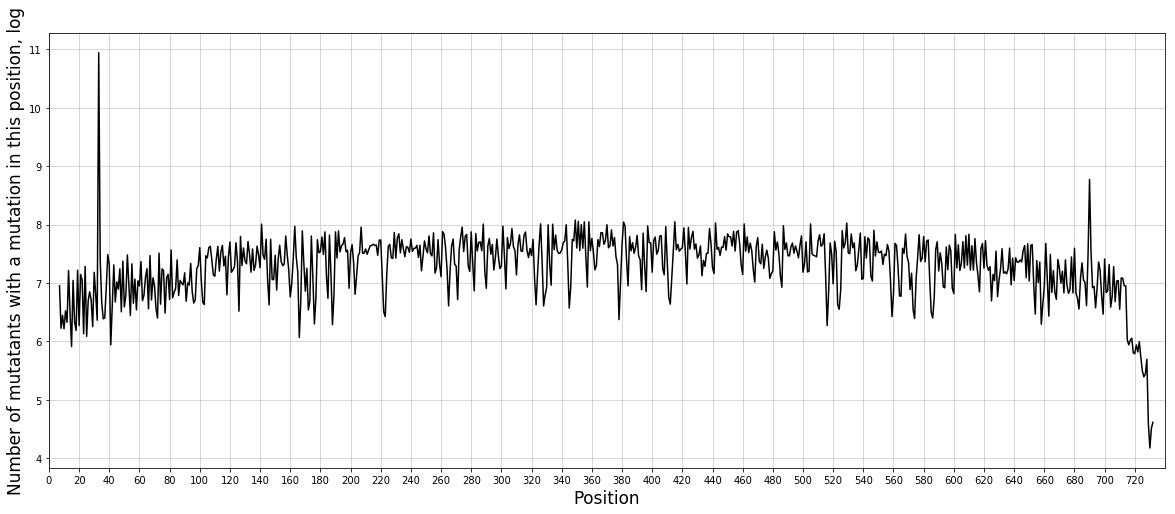

In [86]:
plt.figure(figsize=[20,8])
plt.xticks([x for x in range(0,740,20)])
plt.xlim(0,740)
plt.grid(lw=0.5)
plt.plot([x for x in range(len(true_sq))],[np.log(x) for x in counter],'k-')
plt.xlabel('Position',fontsize=17)
plt.ylabel('Number of mutatants with a mutation in this position, log',fontsize=17);

In [79]:
counter[20:40]

[529,
 1270,
 1154,
 460,
 1457,
 440,
 807,
 943,
 815,
 519,
 1318,
 902,
 580,
 56581,
 1609,
 782,
 594,
 604,
 1012,
 1785]